# Positive breaks XGBoost model - local run with loop

### Peter R.
#### 2024-04-01

Note: Here I use h5p, that is Bfast breaks with h=0.05 or ~ 5% f 20-year time series (ts). Althouh, I explored using h2p and h10p with the 20-yera ts, h5p (the original approach) seems to provide the best overall performance and compromise.

Today (2024-03-04) I meet with MJF to discuss XGB model improvements. An important number of Bfast breaks have very wide confidence intervals (CIs) associated with the time of break. These CIs can range from about 1 month to 80+ months. These won't allow for high quality matching with yearly climate or disturbance data. For this reason, we decided to run XGB models with subsets of data, each subset has narrow CIs. We will run the following XGB models with the follwoing dataframe subsets:

- Dataframe3 (df3): Records with CIs shorter than 3 16-days data points (48 days or about 1.5 months)

- Dataframe6 (df6): Records with CIs shorter than 6 16-days data points (96 days or about 3 months)

- Dataframe9 (df9): Records with CIs shorter than 9 16-days data points (144 days or about 5 months)

- Dataframe23 (df23): Records with CIS shorter than 23 16-days data points (368 days or about 1 year)

Some questions to have in mind:

- How many matches with disturbance data do the above have?
- Why does forest age become the top ranking variable with VIFplust variable set?  This variable was number 10 in other previous XGB model.
- I am assuming that Hansen is best and that it only includes stand-replacing disturbances


In [25]:
# 2024-03-24
# Peter R.
# XGBoost script
# Positive breaks, n_estimators (number of trees)=1000 and with optimal parameter from DRAC model_bp1 & early stopping

#Here I am using a loop to run several models at a time

import os
import time

import pandas as pd
from numpy import nan
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# for feature importance plots
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np

#for dependency plots
from sklearn.inspection import PartialDependenceDisplay

#start = time.time()

# Get the current working directory
cwd = os.getcwd()

#print(cwd)

# DRAC directory
#os.chdir("/home/georod/projects/def-mfortin/georod/scripts/github/forc_trends/models/xgboost")
# Win directory
os.chdir(r'C:\Users\Peter R\github\forc_trends\models\xgboost')


print("XGB version:", xgb.__version__)
print("negative breaks")


# Windows
df1 = pd.read_csv(r'.\data\forest_evi_breaks_positive_v3.csv', skipinitialspace=True)
# DRAC
#df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v2.csv', skipinitialspace=True)
#df1.head()


df11 = pd.get_dummies(df1, columns=['for_pro'], dtype=float)

#Df0: all rows
#df2 = df11 # N=843
# Df3: 1.5 months, version4/df3
#df2 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 0.1315068) & (df11['magnitude'] < -700)] #N= 171
# Df6: 3 months, version4/df6
#df2 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 0.2630137) & (df11['magnitude'] < -700)] #N= 450
# Df9: 5 months, version4/df9
# df2 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 0.3945205) & (df11['magnitude']< -700)] #N=523
# Df23: 12 months, 1 year, version4/df23
#df2 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 1.008219) & (df11['magnitude'] < -700)] #N=649

# Df23v2: 12 months, 1 year, bounded by same year, version4/df23v2
#df2 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 1.008219) & (df11['magnitude'] < -700)] # N=2291
#df2 = df2.loc[(np.floor(df2['brkdate95'])==np.floor(df2['brkdate25']))]


XGB version: 1.7.6
negative breaks


In [39]:
#Df0: all rows
df0 = df11 # N=3935
# Df3: 1.5 months, version4/df3
df3 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 0.1315068) & (df11['magnitude'] > 500)] #N= 40
#Df6: 3 months, version4/df6
df6 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 0.2630137) & (df11['magnitude'] > 500)] #N= 168
# Df9: 6 months, version4/df9
df9 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 0.3945205) & (df11['magnitude'] > 500)] #N=649
# Df23: 12 months, 1 year, version4/df23
df23 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 1.008219) & (df11['magnitude'] > 500)] #N=2216

dfall = [df0,df3, df6, df9, df23]
#dfall = [df0, df6, df9, df23]


In [3]:
#print(df3.describe()) # Too few rows

In [36]:
print(dfall[3].describe()) 

                 pix         year     brk    brkdate25      brkdate  \
count    2216.000000  2216.000000  2216.0  2216.000000  2216.000000   
mean   239112.670126  2013.384928     0.0  2013.581733  2013.862449   
std    145145.808934     5.520602     0.0     5.292896     5.389040   
min       601.000000  2003.000000     0.0  2003.739000  2003.957000   
25%    118101.750000  2009.000000     0.0  2009.293250  2009.565000   
50%    236618.000000  2013.000000     0.0  2013.522000  2013.565000   
75%    371984.000000  2019.000000     0.0  2019.304000  2019.348000   
max    493282.000000  2021.000000     0.0  2021.652000  2021.957000   

         brkdate95    magnitude  no_brk  fire_year    harv_year  ...  \
count  2216.000000  2216.000000     0.0        0.0    81.000000  ...   
mean   2014.122335  1016.516120     NaN        NaN  2010.123457  ...   
std       5.300482   383.575761     NaN        NaN     4.548029  ...   
min    2004.000000   500.746000     NaN        NaN  2004.000000  ...   


In [37]:
(dfall[0]).head()
#range(len(dfall))

,pix,year,brk,brkdate25,brkdate,brkdate95,magnitude,no_brk,fire_year,harv_year,...,bffp,bffp_lag1,bffp_lag2,bffp_lag3,effp,effp_lag1,effp_lag2,effp_lag3,for_pro_0,for_pro_1
0,308165,2005,0,2005.348,2005.391,2006.087,672.967,NaN,NaN,NaN,...,139.000,153.000,148.000,147.883,271.000,267.0,266.0,265.000,1.0,0.0
1,308324,2005,0,2005.565,2005.609,2006.174,1070.553,NaN,NaN,NaN,...,136.282,151.000,146.000,146.000,272.130,268.0,267.0,266.000,1.0,0.0
2,308326,2005,0,2005.565,2005.609,2006.391,1048.369,NaN,NaN,NaN,...,136.317,151.000,146.000,146.000,272.000,268.0,267.0,265.683,1.0,0.0
3,310381,2005,0,2005.348,2005.391,2006.304,781.968,NaN,NaN,NaN,...,136.000,150.964,145.964,146.000,272.354,268.0,267.0,266.000,1.0,0.0
4,124272,2004,0,2004.000,2004.043,2004.130,458.737,NaN,NaN,NaN,...,150.427,145.000,146.000,140.000,269.000,268.0,266.0,270.573,1.0,0.0


In [40]:
# loop version

cols1 = ['for_age', 'for_con', 'map', 'map_lag1', 'map_lag2', 'map_lag3', 'mat', 'mat_lag1', 'mat_lag2', 'mat_lag3', 'rh', 'rh_lag1', 'rh_lag2', 'rh_lag3', 'for_pro_0']
cols2 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3']
cols3 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3', 'for_age', 'for_pro_0']

df_labs = ['df0','df3', 'df6', 'df9', 'df23']
model_labs = ['First variable set', 'VIF variable set', 'VIFplus variable set']

for z in range(len(dfall)):
    list_of_vars = [[cols1], [cols2], [cols3]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            #print(x)
            X1 = dfall[z][x]
            #print(X1.describe())
            y1 = dfall[z].iloc[:,6].abs()
            seed = 7 # random seed to help with replication
            testsize1 = 0.33 # percent of records to test after training
            x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
            model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=50,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.01, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=8, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=1000, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
               # EVALUATION (with test)
            eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
                #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
            model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
                # make predictions for test data
            y_pred = model_bp2.predict(x1_test)
            predictions = [round(value) for value in y_pred]
                # retrieve performance metrics
            results = model_bp2.evals_result()
            mse = mean_squared_error(y1_test, y_pred)
                #r2 = explained_variance_score(y1_test, ypred)
            r2 = r2_score(y1_test, y_pred)
                # adjusted R-squared
            adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))

            #print("MSE: %.2f" % mse)
            var1 = "%.2f" % mse

            #print("RMSE: %.2f" % (mse**(1/2.0)))
            var2 = "%.2f" % (mse**(1/2.0))

            #print("R-sq: %.3f" % r2)
            var3 = "%.3f" % r2

            #print("R-sq-adj: %.3f" % adj_r2)
            var4 = "%.3f" % adj_r2

            var5 = X1.shape[0]
            var6 = X1.shape[1]

            # row for table
            #print("| %.2f" % mse, "| %.2f" % (mse**(1/2.0)), "| %.3f" % r2, "| %.3f" % adj_r2, "|", X1.shape[0], "|", X1.shape[1],"|")
            #print("|", z+1, "|", df_labs[z], "|", model_labs[index], "| %.2f" % mse, "| %.2f" % (mse**(1/2.0)), "| %.3f" % r2, "| %.3f" % adj_r2, "|", X1.shape[0], "|", X1.shape[1],"|")
            print("|", (z+1), "|", df_labs[z], "|", model_labs[index], "|", var1, "|", var2, "|", var3, "|", var4, "|",var5, "|",var6, "|")
            # Feature importance plot
            #xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
            #            xlabel='F score - Gain', ylabel='Features', 
            #            importance_type='gain', max_num_features=15, grid=True, show_values=False) #, values_format='{v:.2f}' )

            #pyplot.savefig(r'.\figs\version4\h2p\df23\neg_gain_m{y}_v1.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
            #pyplot.show()
            # create lis of feature names to be used in dependency plot so that high ranking vars are plotted
            #features_names1 = pd.DataFrame()
           # features_names1['columns'] = X1.columns
           # features_names1['importances'] = model_bp2.feature_importances_
           # features_names1.sort_values(by='importances',ascending=False,inplace=True)
           # features_names2 = features_names1['columns'].tolist()[0:10]

           # _, ax1 = plt.subplots(figsize=(9, 8), constrained_layout=True)

           # display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

           # _ = display.figure_.suptitle(("Partial dependence plots"), fontsize=12, )

           # pyplot.savefig(r'.\figs\version4\h2p\df23\neg_partial_dep_m{y}_v1.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')

           # pyplot.show()
        

| 1 | df0 | First variable set | 101545.85 | 318.66 | 0.331 | 0.323 | 3935 | 15 |
| 1 | df0 | VIF variable set | 102425.49 | 320.04 | 0.325 | 0.321 | 3935 | 7 |
| 1 | df0 | VIFplus variable set | 100565.73 | 317.12 | 0.337 | 0.333 | 3935 | 9 |
| 2 | df3 | First variable set | 92064.40 | 303.42 | 0.069 | 7.053 | 40 | 15 |
| 2 | df3 | VIF variable set | 961633.21 | 980.63 | -8.727 | -20.075 | 40 | 7 |
| 2 | df3 | VIFplus variable set | 983816.48 | 991.88 | -8.952 | -31.342 | 40 | 9 |
| 3 | df6 | First variable set | 429397.33 | 655.28 | 0.277 | 0.006 | 168 | 15 |
| 3 | df6 | VIF variable set | 414451.90 | 643.78 | 0.302 | 0.200 | 168 | 7 |
| 3 | df6 | VIFplus variable set | 446827.37 | 668.45 | 0.248 | 0.100 | 168 | 9 |
| 4 | df9 | First variable set | 205022.31 | 452.79 | 0.168 | 0.105 | 649 | 15 |
| 4 | df9 | VIF variable set | 187066.63 | 432.51 | 0.240 | 0.215 | 649 | 7 |
| 4 | df9 | VIFplus variable set | 199167.64 | 446.28 | 0.191 | 0.156 | 649 | 9 |
| 5 | df23 | First variable set

**Table 1**: Model comparison for positive breaks. Standard data set with all records (including NAs for for_age and for_con).


|ID|Data frame| Model   | MSE| RMSE| R-sq | R-sq-adj |N rows| N vars|
| --------| --------| --------| --------| -------- | ------- |-------- | ------- |------- |
| 1 | df0 | First variable set | 101545.85 | 318.66 | 0.331 | 0.323 | 3935 | 15 |
| 2 | df0 | VIF variable set | 102425.49 | 320.04 | 0.325 | 0.321 | 3935 | 7 |
| 3 | df0 | VIFplus variable set | 100565.73 | 317.12 | 0.337 | 0.333 | 3935 | 9 |
| 4 | df3 | First variable set | 92064.40 | 303.42 | 0.069 | 7.053 | 40 | 15 |
| 5 | df3 | VIF variable set | 961633.21 | 980.63 | -8.727 | -20.075 | 40 | 7 |
| 6 | df3 | VIFplus variable set | 983816.48 | 991.88 | -8.952 | -31.342 | 40 | 9 |
| 7 | df6 | First variable set | 429397.33 | 655.28 | 0.277 | 0.006 | 168 | 15 |
| 8 | df6 | VIF variable set | 414451.90 | 643.78 | 0.302 | 0.200 | 168 | 7 |
| 9 | df6 | VIFplus variable set | 446827.37 | 668.45 | 0.248 | 0.100 | 168 | 9 |
| 10 | df9 | First variable set | 205022.31 | 452.79 | 0.168 | 0.105 | 649 | 15 |
| 11 | df9 | VIF variable set | 187066.63 | 432.51 | 0.240 | 0.215 | 649 | 7 |
| 12 | df9 | VIFplus variable set | 199167.64 | 446.28 | 0.191 | 0.156 | 649 | 9 |
| 13 | df23 | First variable set | 108384.69 | 329.22 | 0.345 | 0.331 | 2216 | 15 |
| 14 | df23 | VIF variable set | 117880.80 | 343.34 | 0.288 | 0.281 | 2216 | 7 |
| 15 | df23 | VIFplus variable set | 106324.50 | 326.07 | 0.357 | 0.349 | 2216 | 9 |









In [137]:
# Misc cmds
#Describe the data
#X1 = df2[x]
#print(X1.shape)
#x
#print(len(cols1))
# Count NAs per columns to check that step above worked #mat 607 before, now 0
#X1.isna().sum()

In [138]:
#X1.describe()

### Models without records that have disturbance matches

When dealing with positive forest EVI breaks, those records matched with disturbance data can be considered noise. Below I remove positive breaks matched to Hansen et al.'s disturbance data. Note that df3 is ommitted because it has no records dur to filtering above.

In [139]:
# How many records are matched to disturbance data?
#print(df2[['hansen_year']].describe()) # N=2775
#print(df2[['magnitude', 'fire_year', 'harv_year', 'canlad_year', 'hansen_year']].describe()) # Hansen=? with df4; Hansen=648 with df5

In [41]:
# Df0: all records
#df0 = df11 # N=687
df0 = df0.loc[df0['hansen_year'].isnull()]
# Df3: 1.5 months
#df3 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 0.1315068) & (df11['magnitude']> 700)] #N=40
df3 = df3.loc[df3['hansen_year'].isnull()]
# Df6: 3 months
#df6 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 0.2630137) & (df11['magnitude']> 700)] #N=168
df6 = df6.loc[df6['hansen_year'].isnull()] #N=168
# Df9: 5 months, version 4
#df9 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 0.3945205) & (df11['magnitude']> 700)] #N=649
df9 = df9.loc[df9['hansen_year'].isnull()] 
# Df23: 12 months, 1 year, version 5
#df23 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 1.008219) & (df11['magnitude']> 700)] #N=2216
df23 = df23.loc[df23['hansen_year'].isnull()] 
#dfall = [[df0],[df3], [df6], [df9], [df23]]
#dfall = [df0, df3, df6, df9, df23]
dfall = [df0, df6, df9, df23]

In [141]:
#print(df2[['canlad_year']].describe()) # 2483; 247
#print(df2[['harv_year']].describe()) # 1187; 204
#print(df2[['fire_year']].describe()) # 139; 107

In [142]:
# This produces an empty df as there are no records
#df3 = df2.drop(df2[df2.hansen_year > 0].index)
#X3.tail
#X3.shape
#df3.describe()
#df2.drop(df2[df2.hansen_year > 0].index, inplace=True) # gives a warning
#df2.shape

#df2 = df2.loc[df2['hansen_year'] > 0] # 2775

#df2 = df2.loc[df2['hansen_year'].isnull()]

#df2.shape

In [143]:
#df2.drop(df2[df2.hansen_year > 0].index).describe()

In [42]:
dfall[3].shape

(1759, 158)

In [43]:
# loop version

cols1 = ['for_age', 'for_con', 'map', 'map_lag1', 'map_lag2', 'map_lag3', 'mat', 'mat_lag1', 'mat_lag2', 'mat_lag3', 'rh', 'rh_lag1', 'rh_lag2', 'rh_lag3', 'for_pro_0']
cols2 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3']
cols3 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3', 'for_age', 'for_pro_0']

#df_labs = ['df0','df3', 'df6', 'df9', 'df23']
df_labs = ['df0', 'df6','df9', 'df23']
model_labs = ['First variable set', 'VIF variable set', 'VIFplus variable set']

for z in range(len(dfall)):
    list_of_vars = [ [cols1], [cols2], [cols3]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            #print(x)
            X1 = dfall[z][x]
            #print(X1.describe())
            y1 = dfall[z].iloc[:,6].abs()
            seed = 7 # random seed to help with replication
            testsize1 = 0.33 # percent of records to test after training
            x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
            model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=50,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.01, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=8, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=1000, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
               # EVALUATION (with test)
            eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
                #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
            model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
                # make predictions for test data
            y_pred = model_bp2.predict(x1_test)
            predictions = [round(value) for value in y_pred]
                # retrieve performance metrics
            results = model_bp2.evals_result()
            mse = mean_squared_error(y1_test, y_pred)
                #r2 = explained_variance_score(y1_test, ypred)
            r2 = r2_score(y1_test, y_pred)
                # adjusted R-squared
            adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))

            #print("MSE: %.2f" % mse)
            var1 = "%.2f" % mse

            #print("RMSE: %.2f" % (mse**(1/2.0)))
            var2 = "%.2f" % (mse**(1/2.0))

            #print("R-sq: %.3f" % r2)
            var3 = "%.3f" % r2

            #print("R-sq-adj: %.3f" % adj_r2)
            var4 = "%.3f" % adj_r2

            var5 = X1.shape[0]
            var6 = X1.shape[1]

             # row for table
            #print("| %.2f" % mse, "| %.2f" % (mse**(1/2.0)), "| %.3f" % r2, "| %.3f" % adj_r2, "|", X1.shape[0], "|", X1.shape[1],"|")
            print("|", (z+1), "|", df_labs[z], "|", model_labs[index], "|", var1, "|", var2, "|", var3, "|", var4, "|",var5, "|",var6, "|")
            # Feature importance plot
            #xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
            #            xlabel='F score - Gain', ylabel='Features', 
            #            importance_type='gain', max_num_features=15, grid=True, show_values=False) #, values_format='{v:.2f}' )

            #pyplot.savefig(r'.\figs\version4\h2p\df23\neg_gain_m{y}_v2.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
            #pyplot.show()
            # create lis of feature names to be used in dependency plot so that high ranking vars are plotted
            #features_names1 = pd.DataFrame()
            #features_names1['columns'] = X1.columns
            #features_names1['importances'] = model_bp2.feature_importances_
            #features_names1.sort_values(by='importances',ascending=False,inplace=True)
            #features_names2 = features_names1['columns'].tolist()[0:10]

            #_, ax1 = plt.subplots(figsize=(9, 8), constrained_layout=True)

            #display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

            #_ = display.figure_.suptitle(("Partial dependence plots"), fontsize=12, )

            #pyplot.savefig(r'.\figs\version4\h2p\df23\neg_partial_dep_m{y}_v2.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')

            #pyplot.show()

| 1 | df0 | First variable set | 96438.93 | 310.55 | 0.357 | 0.348 | 3263 | 15 |
| 1 | df0 | VIF variable set | 97848.66 | 312.81 | 0.348 | 0.344 | 3263 | 7 |
| 1 | df0 | VIFplus variable set | 96362.44 | 310.42 | 0.358 | 0.352 | 3263 | 9 |
| 2 | df6 | First variable set | 627128.07 | 791.91 | 0.012 | -0.537 | 130 | 15 |
| 2 | df6 | VIF variable set | 559673.88 | 748.11 | 0.118 | -0.058 | 130 | 7 |
| 2 | df6 | VIFplus variable set | 555182.14 | 745.11 | 0.125 | -0.113 | 130 | 9 |
| 3 | df9 | First variable set | 205262.67 | 453.06 | 0.169 | 0.084 | 491 | 15 |
| 3 | df9 | VIF variable set | 209576.92 | 457.80 | 0.151 | 0.113 | 491 | 7 |
| 3 | df9 | VIFplus variable set | 212155.69 | 460.60 | 0.141 | 0.090 | 491 | 9 |
| 4 | df23 | First variable set | 105563.15 | 324.90 | 0.243 | 0.222 | 1759 | 15 |
| 4 | df23 | VIF variable set | 120538.11 | 347.19 | 0.135 | 0.125 | 1759 | 7 |
| 4 | df23 | VIFplus variable set | 109900.17 | 331.51 | 0.211 | 0.199 | 1759 | 9 |


**Table 2**: Model comparison for positive breaks. Subset of data records was used, excluding records that had a match with disturbance data. (Some NAs for for_age and for_con.)

|ID| Data frame| Model   | MSE| RMSE| R-sq | R-sq-adj | N rows| N vars|
| --------| --------| -------- | ------- |-------- | ------- |------- |------- |------- |
| 1 | df0 | First variable set | 96438.93 | 310.55 | 0.357 | 0.348 | 3263 | 15 |
| 2 | df0 | VIF variable set | 97848.66 | 312.81 | 0.348 | 0.344 | 3263 | 7 |
| 3 | df0 | VIFplus variable set | 96362.44 | 310.42 | 0.358 | 0.352 | 3263 | 9 |
| 4 | df6 | First variable set | 627128.07 | 791.91 | 0.012 | -0.537 | 130 | 15 |
| 5 | df6 | VIF variable set | 559673.88 | 748.11 | 0.118 | -0.058 | 130 | 7 |
| 6 | df6 | VIFplus variable set | 555182.14 | 745.11 | 0.125 | -0.113 | 130 | 9 |
| 7 | df9 | First variable set | 205262.67 | 453.06 | 0.169 | 0.084 | 491 | 15 |
| 8 | df9 | VIF variable set | 209576.92 | 457.80 | 0.151 | 0.113 | 491 | 7 |
| 9 | df9 | VIFplus variable set | 212155.69 | 460.60 | 0.141 | 0.090 | 491 | 9 |
| 10 | df23 | First variable set | 105563.15 | 324.90 | 0.243 | 0.222 | 1759 | 15 |
| 11 | df23 | VIF variable set | 120538.11 | 347.19 | 0.135 | 0.125 | 1759 | 7 |
| 12 | df23 | VIFplus variable set | 109900.17 | 331.51 | 0.211 | 0.199 | 1759 | 9 |






In [15]:
# check one more
# df2.shape
X1.shape

(1759, 9)

### Best Model

The best model for positive breaks was ID=3 (df0, VIFplus variable set) with removed disturbance record matches. I filtered out breaks by removing a small set that matched with disturbance data. I assume positive break records matched with disturbance data are noise/error as the disturbance data used here (i.e., fire, harvest, pests, etc.) are normally associated with negative breaks rather than positive ones.

Below are the corresponding plots for this model.

In [44]:
dfall2 = [df0] # This df0 is from the distubance filtered version

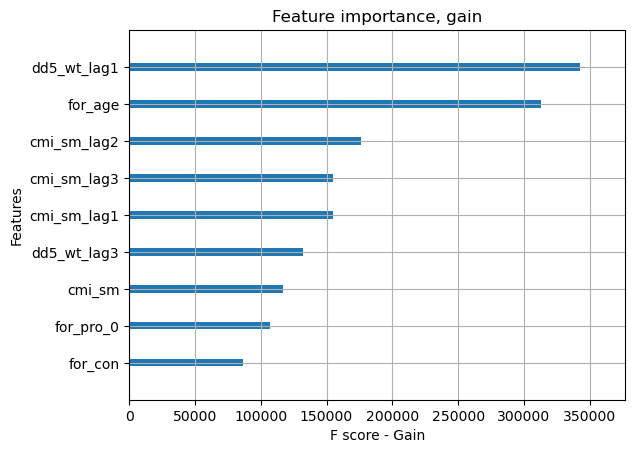

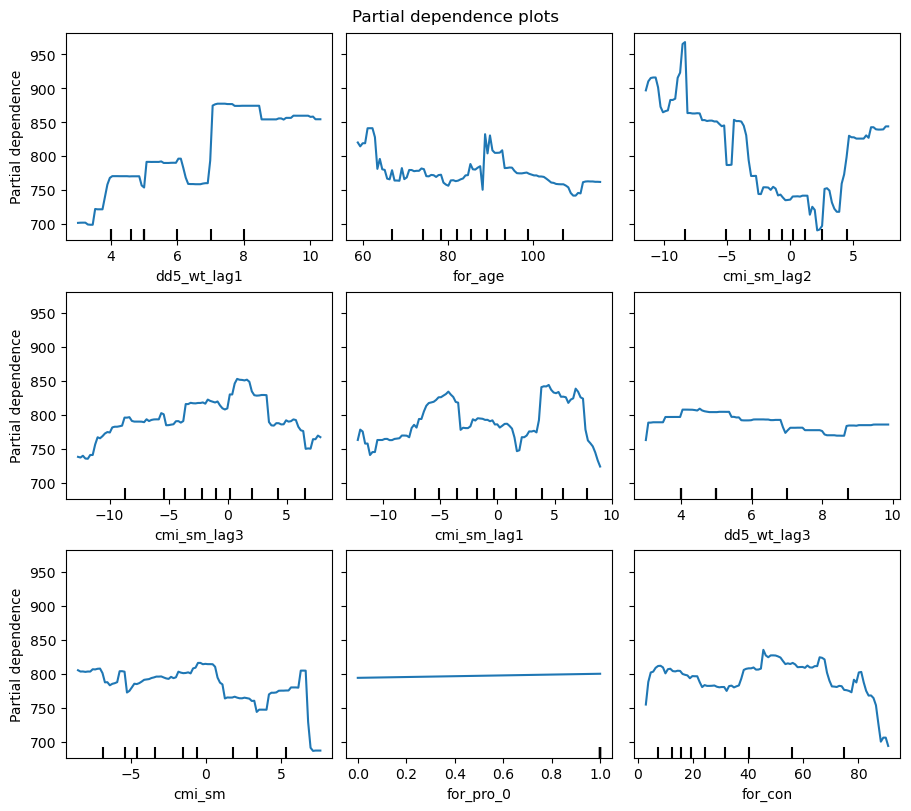

In [45]:
# loop version

#cols1 = ['for_age', 'for_con', 'map', 'map_lag1', 'map_lag2', 'map_lag3', 'mat', 'mat_lag1', 'mat_lag2', 'mat_lag3', 'rh', 'rh_lag1', 'rh_lag2', 'rh_lag3', 'for_pro_0']
#cols2 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3']
cols3 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3', 'for_age', 'for_pro_0']

for z in range(len(dfall2)):
    list_of_vars = [[cols3]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            #print(x)
            X1 = dfall2[z][x]
            #print(X1.describe())
            y1 = dfall2[z].iloc[:,6].abs()
            seed = 7 # random seed to help with replication
            testsize1 = 0.33 # percent of records to test after training
            x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
            model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=50,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.01, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=8, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=1000, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
               # EVALUATION (with test)
            eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
                #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
            model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
                # make predictions for test data
            y_pred = model_bp2.predict(x1_test)
            predictions = [round(value) for value in y_pred]
                # retrieve performance metrics
            results = model_bp2.evals_result()
            mse = mean_squared_error(y1_test, y_pred)
                #r2 = explained_variance_score(y1_test, ypred)
            r2 = r2_score(y1_test, y_pred)
                # adjusted R-squared
            adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))

            #print("MSE: %.2f" % mse)

            #print("RMSE: %.2f" % (mse**(1/2.0)))

            #print("R-sq: %.3f" % r2)

            #print("R-sq-adj: %.3f" % adj_r2)
            
            
            # Feature importance plot
            xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                        xlabel='F score - Gain', ylabel='Features', 
                        importance_type='gain', max_num_features=15, grid=True, show_values=False) #, values_format='{v:.2f}' )

            pyplot.savefig(r'.\figs\version5\pos_gain_m{y}_v1.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
            #pyplot.show()
            
            # create lis of feature names to be used in dependency plot so that high ranking vars are plotted
            features_names1 = pd.DataFrame()
            features_names1['columns'] = X1.columns
            features_names1['importances'] = model_bp2.feature_importances_
            features_names1.sort_values(by='importances',ascending=False,inplace=True)
            features_names2 = features_names1['columns'].tolist()[0:10]

            # Partial dependence plots
            _, ax1 = plt.subplots(figsize=(9, 8), constrained_layout=True)

            display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

            _ = display.figure_.suptitle(("Partial dependence plots"), fontsize=12, )

            pyplot.savefig(r'.\figs\version5\pos_partial_dep_m{y}_v1.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')

            pyplot.show()


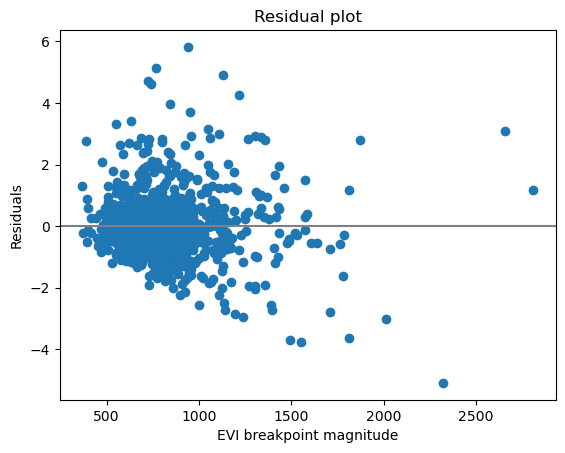

In [46]:
# Model prediction residuals

residuals = y1_test-y_pred

mean = residuals.mean()
std = residuals.std()

std_residuals = (residuals - mean)/std


pyplot.scatter(y_pred, std_residuals)

pyplot.ylabel('Residuals')
pyplot.xlabel("EVI breakpoint magnitude")
pyplot.title('Residual plot')
pyplot.axhline(0, color="gray")

pyplot.show()

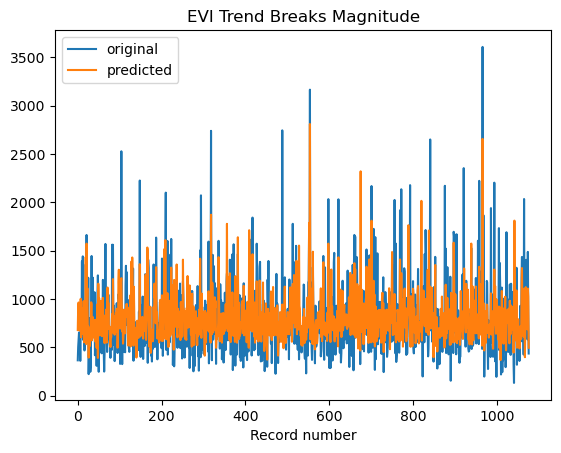

In [47]:
#import matplotlib.pyplot as plt

x_ax = range(len(y1_test))
pyplot.plot(x_ax, y1_test, label="original")
pyplot.plot(x_ax, y_pred, label="predicted")

pyplot.xlabel("Record number") # Order of observations/records in vector

pyplot.title("EVI Trend Breaks Magnitude")

pyplot.legend()

pyplot.savefig(r'.\figs\version5\pos_predicted_m{y}_v1.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')

pyplot.show()

In [48]:
# Plot tree. Use rankdir='LR' to make the plot show sideways
import graphviz

#fig, ax = pyplot.subplots(figsize=(8, 6)) #plt.figure(2, figsize=(8, 6))

format = 'png' #You should try the 'svg'

image = xgb.to_graphviz(model_bp2, num_trees = model_bp2.best_iteration) # best_iteration only works with early_stop_rounds

#Set a different dpi (works only if format == 'png')
image.graph_attr = {'dpi':'300'}

#image.render(r'.\figs\pos_decision_tree6.png', format = format)
image.render(r'.\figs\version5\pos_decision_tree_m{y}_v1.png'.format(y=len(x)), format = format)

#-#image

'figs\\version5\\pos_decision_tree_m9_v1.png.png'